In [1]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise_array, generate_noise
from src.preprocessing import process_image, process_video
from src.gradient_descent import find_default_params
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tqdm import tqdm

In [2]:
size = 400
skip_size=24
L=50
im_thresh = 0.3
noise_thresh = 0.2
smooth = 2.4

In [3]:
im = process_video('images/cheese_gel.avi', threshold=im_thresh, size=size, smooth=1, skip_size=skip_size)
im = im[:7]

In [4]:
# im.shape

In [5]:
def model(thresh, smooth):
    noise = generate_noise_array(size=size, threshold=thresh, smooth=smooth, amount=2)
    F, G = analyse_video(noise, L=L)
    return np.mean([i / j for i, j in zip(F, G)], axis=0)

def loss_fn(y, thresh, smooth, pthresh, psmooth, w):
    return np.sum((model(thresh, smooth) - y)**2) + w*((thresh - pthresh)**2 + 0.5*(smooth - psmooth)**2)

In [6]:
max_iter = 20
h = 0.01
learning_rate = 0.01
w_list= [1, 0.2, 0.04, 0.008, 0]

loss_all = []
params = []
prior_smooth, prior_thresh = find_default_params(im[0])

for frame in tqdm(im):
    F, G = analyse_image(frame, L=L)
    y = F/G
    loss_list = []
    for w in w_list:
        for i in range(max_iter):
            loss = loss_fn(y, noise_thresh, smooth, prior_thresh, prior_smooth, w)
            grad1 = (loss_fn(y, noise_thresh+h, smooth, prior_thresh, prior_smooth, w)-loss)/h
            grad2 = (loss_fn(y, noise_thresh, smooth+h, prior_thresh, prior_smooth,  w)-loss)/h
            
            noise_thresh -= grad1 * learning_rate
            smooth -= grad2 * learning_rate
            
            loss_list.append(loss)
        #print("Loss = " + str(loss))
        # print(thresh_loss)
        # print(disk_loss)
        # print(grad1)
        # print(grad2)
        #print("thresh, smooth = " + str(noise_thresh) + ", " + str(smooth))
        # print("done")
    loss_all.append(loss_list)
    params.append((smooth,noise_thresh))
    prior_thresh = noise_thresh
    prior_smooth = smooth
    

100%|██████████| 7/7 [1:40:28<00:00, 861.18s/it]


In [7]:
print(params)

[(2.5045891021805815, 0.2550168108463213), (2.5055808720933874, 0.23142073699094692), (2.515201214384155, 0.2040541179838772), (2.521388742368899, 0.18055266383708088), (2.5650979286652196, 0.1686974300694411), (2.5800816637299873, 0.16631233430992237), (2.62037301239601, 0.16369889996315873)]


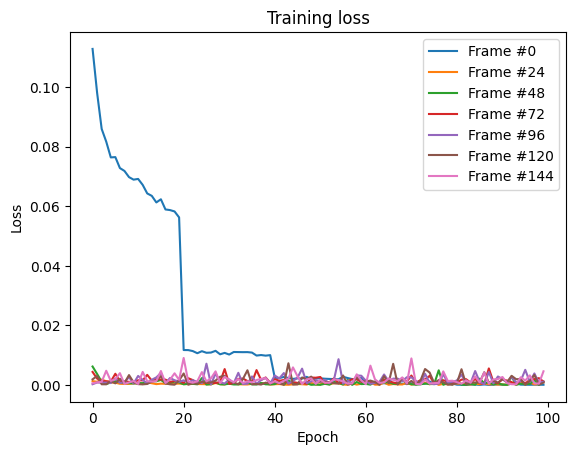

In [8]:
plt.tight_layout()
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for i, loss in enumerate(loss_all):
    plt.plot(loss, label='Frame #{}'.format(i*skip_size))
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

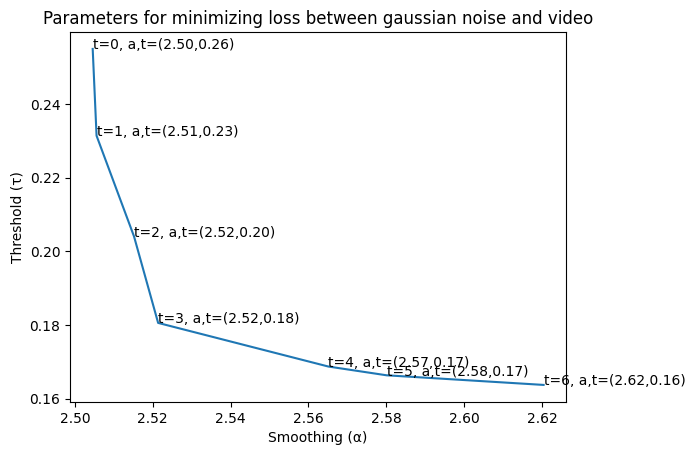

In [19]:
a, t = np.array(params).T
plt.plot(a, t)
for i, (x,y) in enumerate(params):
    plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
plt.title('Parameters for minimizing loss between gaussian noise and video')
plt.xlabel('Smoothing (α)')
plt.ylabel('Threshold (τ)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

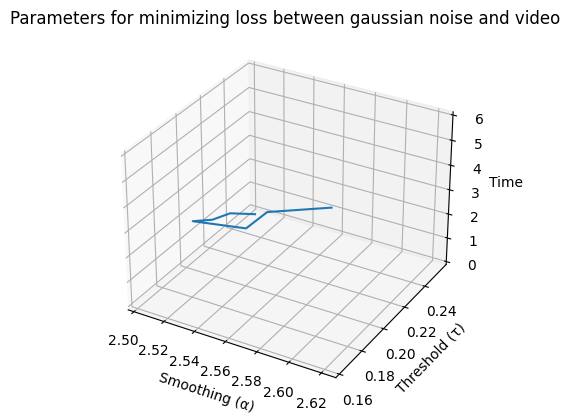

In [17]:
a, t = np.array(params).T
i = np.arange(len(a))

fig = plt.figure()

ax = plt.axes(projection ='3d')
ax.plot(a, t, i)
# for i, (x,y) in enumerate(params):
#     plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
ax.set_title('Parameters for minimizing loss between gaussian noise and video')
ax.set_xlabel('Smoothing (α)')
ax.set_ylabel('Threshold (τ)')
ax.set_zlabel('Time')
plt.show

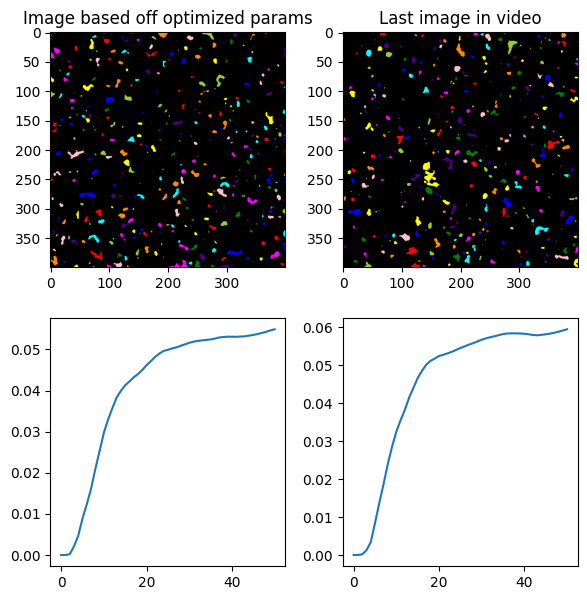

In [18]:
noise = generate_noise(size, threshold=t[-1], smooth=a[-1])
F_noise, G_noise = analyse_image(noise, L=L)
F, G = analyse_image(im[-1], L=L)

fig, ax = plt.subplots(2,2, figsize=(6,6))
plt.tight_layout()

ax[0,0].set_title('Image based off optimized params')
ax[0,0].imshow(label2rgb(noise))
ax[1,0].plot(F_noise/G_noise)

ax[0,1].set_title('Last image in video')
ax[0,1].imshow(label2rgb(im[-1]))
ax[1,1].plot(F/G)
plt.show()

In [12]:
noise1 = generate_noise(size, threshold=t[0], smooth=a[0])
noise2 = generate_noise(size, threshold=t[3], smooth=a[3])
noise3 = generate_noise(size, threshold=t[-1], smooth=a[-1])

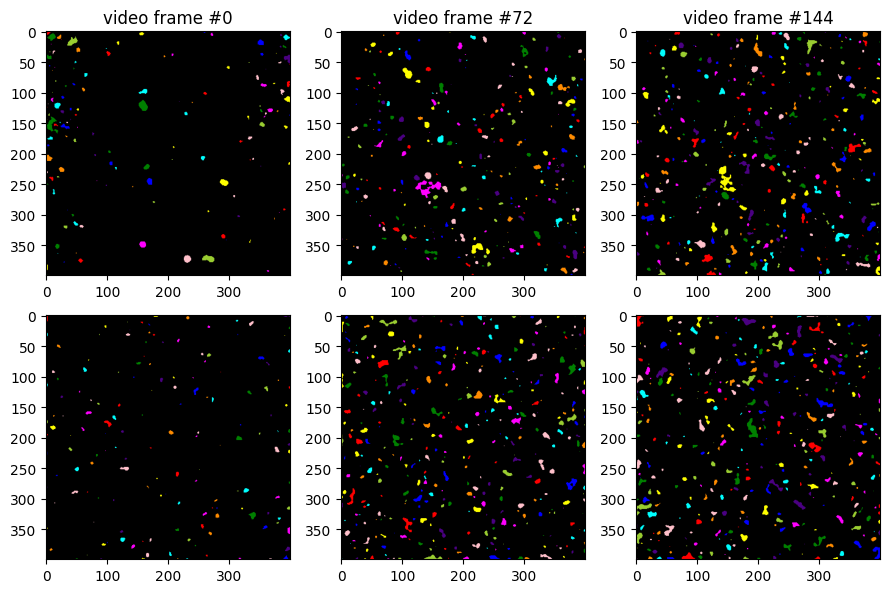

In [13]:
fig, ax = plt.subplots(2,3, figsize=(9,6))

ax[0,0].set_title('video frame #0')
ax[0,0].imshow(label2rgb(im[0]))
ax[0,1].set_title('video frame #72')
ax[0,1].imshow(label2rgb(im[3]))
ax[0,2].set_title('video frame #144')
ax[0,2].imshow(label2rgb(im[-1]))

# ax[1,0].set_title('generated from frame #0')
ax[1,0].imshow(label2rgb(noise1))
# ax[1,1].set_title('generated from frame #72')
ax[1,1].imshow(label2rgb(noise2))
# ax[1,2].set_title('generated from frame #144')
ax[1,2].imshow(label2rgb(noise3))

plt.tight_layout()
# plt.axis('off')
plt.show()

In [14]:
F1, G1 = analyse_image(im[0], L=L)
F2, G2 = analyse_image(im[3], L=L)
F3, G3 = analyse_image(im[-1], L=L)

Fn1, Gn1 = analyse_image(noise1, L=L)
Fn2, Gn2 = analyse_image(noise2, L=L)
Fn3, Gn3 = analyse_image(noise3, L=L)

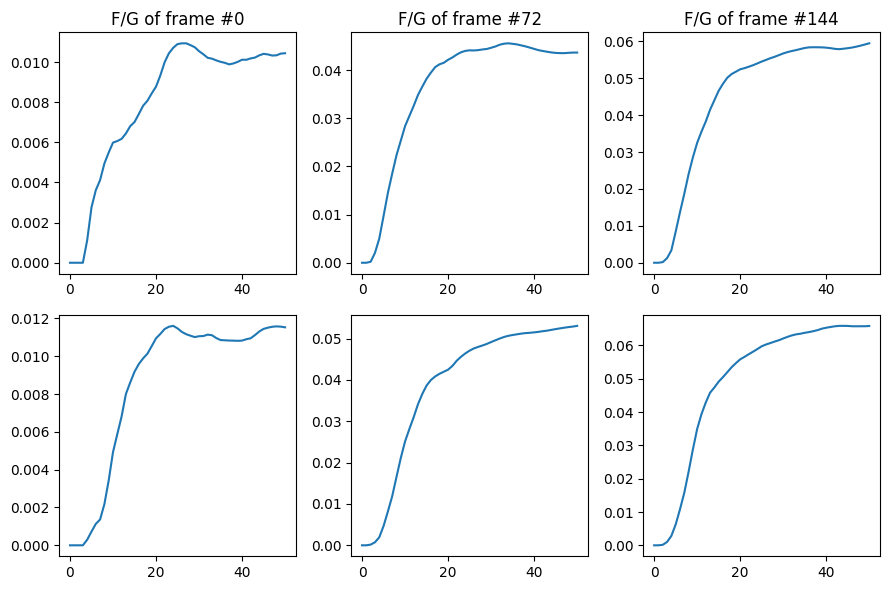

In [15]:
fig, ax = plt.subplots(2,3, figsize=(9,6))

ax[0,0].set_title('F/G of frame #0')
ax[0,0].plot(F1/G1)
ax[0,1].set_title('F/G of frame #72')
ax[0,1].plot(F2/G2)
ax[0,2].set_title('F/G of frame #144')
ax[0,2].plot(F3/G3)

# ax[1,0].set_title(' from frame #0')
ax[1,0].plot(Fn1/Gn1)
# ax[1,1].set_title('generated from frame #120')
ax[1,1].plot(Fn2/Gn2)
# ax[1,2].set_title('generated from frame #240')
ax[1,2].plot(Fn3/Gn3)

plt.tight_layout()
plt.show()

In [16]:
# def stochastic_loss(thresh, disk):
#     noise = generate_noise(size=size, threshold=thresh, disk_size=disk, amount=4)
#     res_list = stochastic_analyse_video(noise, L=50)
#     return np.mean([(i[0] - y[i[1]])**2 for i in res_list])